Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [118]:
!pip install print-versions

In [98]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [120]:
from print_versions import print_versions

print_versions(globals())

tensorflow==2.17.0
numpy==1.26.4
pandas==2.2.2
PIL==10.4.0
tensorflow.keras==3.5.0
keras==3.5.0
Augmentor==0.2.12


In [99]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [100]:
path = fr"{os.getcwd()}\Skin_Cancer_Images"
path

'C:\\Users\\Siddhant.Ghute\\Desktop\\LJMU\\4. Course - Deep Learning 1\\CNN\\Melanoma_Assignment\\Skin_Cancer_Images'

In [101]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(fr"{path}\train")
data_dir_test = pathlib.Path(fr"{path}\test")

In [102]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [103]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [104]:
# ?tf.keras.preprocessing.image_dataset_from_directory

In [105]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    subset="training"
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [106]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    subset="validation"
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [107]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [108]:
str(list(data_dir_train.glob(fr"{class_names[5]}/*.jpg"))[1])

'C:\\Users\\Siddhant.Ghute\\Desktop\\LJMU\\4. Course - Deep Learning 1\\CNN\\Melanoma_Assignment\\Skin_Cancer_Images\\train\\pigmented benign keratosis\\ISIC_0024445.jpg'

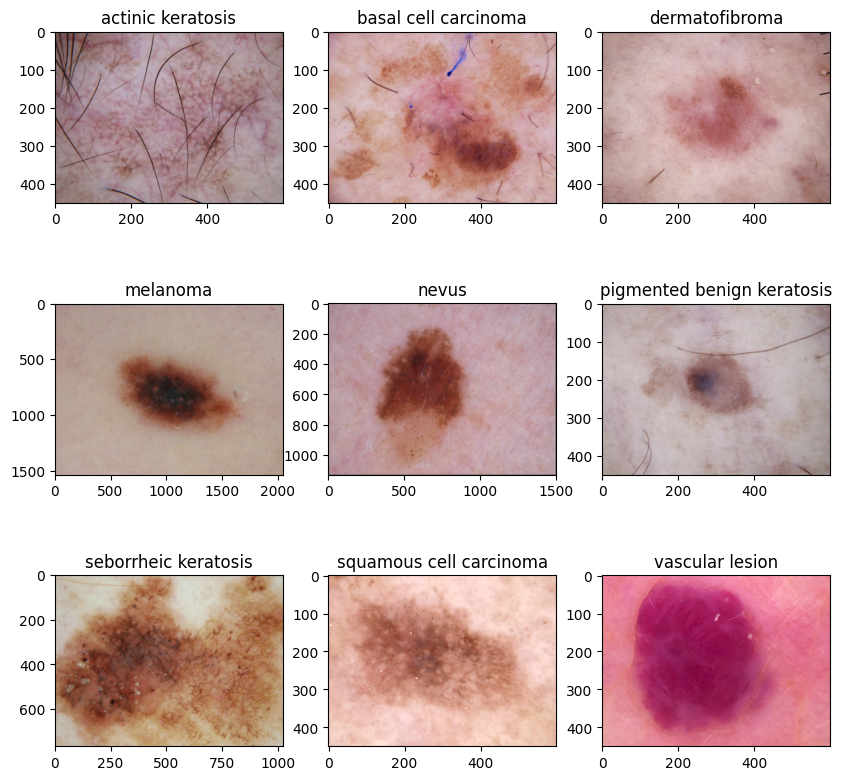

In [109]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10,10))

for sp in range(9):
    plt.subplot(3,3, sp+1)
    image_path = str(list(data_dir_train.glob(fr"{class_names[sp]}/*.jpg"))[1])
    image = plt.imread(image_path)
    plt.title(class_names[sp])
    plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
? tf.data.experimental.AUTOTUNE

Type:        int
String form: -1
Docstring:  
int([x]) -> integer
int(x, base=10) -> integer

Convert a number or string to an integer, or return 0 if no arguments
are given.  If x is a number, return x.__int__().  For floating-point
numbers, this truncates towards zero.

If x is not a number or if base is given, then x must be a string,
bytes, or bytearray instance representing an integer literal in the
given base.  The literal can be preceded by '+' or '-' and be surrounded
by whitespace.  The base defaults to 10.  Valid bases are 0 and 2-36.
Base 0 means to interpret the base from the string as an integer literal.
>>> int('0b100', base=0)
4

In [110]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [111]:
### Your code goes here
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D

classes = len(class_names)

# initiate with rescaling
model = Sequential(name="First_Model")

# add other layers
model.add(layers.Rescaling(scale=1.0 / 255, input_shape=(img_height, img_width, 3)))

model.add(
    Conv2D(
        filters=32,
        kernel_size=(5, 5),
        padding="Same",
        activation="relu",
        input_shape=(180, 180, 32),
    )
)

model.add(
    Conv2D(
        filters=32,
        kernel_size=(5, 5),
        padding="Same",
        activation="relu",
    )
)

model.add(MaxPool2D(pool_size=(2, 2)))

model.add(
    Conv2D(
        filters=32,
        kernel_size=(5, 5),
        padding="Same",
        activation="relu",
    )
)

model.add(MaxPool2D(pool_size=(2, 2)))

model.add(
    Conv2D(
        filters=64,
        kernel_size=(5, 5),
        padding="Same",
        activation="relu",
    )
)

model.add(MaxPool2D(pool_size=(2, 2)))

model.add(
    Conv2D(
        filters=64,
        kernel_size=(5, 5),
        padding="Same",
        activation="relu",
    )
)

model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(classes, activation="softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [112]:
### Todo, choose an appropirate optimiser and loss function
# Sparse Categorical Cross-Entropy: Use this when your target variable is an integer representing the class index.
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
              loss= "sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [113]:
# View the summary of all layers
model.summary()

Model: "First_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 180, 180, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 180, 180, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 90, 90, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 45, 45, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 22, 22, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 7744)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │          69,705 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 277,129 (1.06 MB)

 Trainable params: 277,129 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [114]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.1685 - loss: 2.1181 - val_accuracy: 0.2058 - val_loss: 2.0270
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.2002 - loss: 2.0111 - val_accuracy: 0.2103 - val_loss: 2.0348
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.1746 - loss: 2.0260 - val_accuracy: 0.2550 - val_loss: 2.0299
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.2216 - loss: 2.0141 - val_accuracy: 0.1924 - val_loss: 2.0463
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.2018 - loss: 2.0013 - val_accuracy: 0.1902 - val_loss: 2.0529
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.2048 - loss: 2.0054 - val_accuracy: 0.1902 - val_loss: 2.0468
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.2368 - loss: 1.9908 - val_accuracy: 0.1566 - val_loss: 2.0392
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.1966 - loss: 2.0220 - val_accuracy: 0.2081 - val_lo

### Visualizing training results

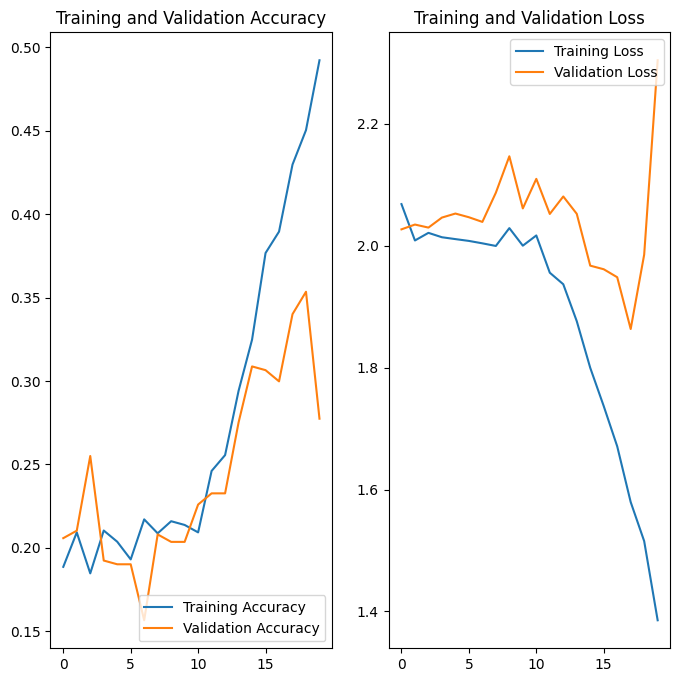

In [115]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

Observations:
1. Training and Validation Accuracy (Left Chart):
- Both training and validation accuracy generally increase over epochs.
- Training accuracy appears to improve consistently, while validation accuracy fluctuates more but follows a similar upward trend.
- There is a divergence towards the end, where training accuracy continues to improve while validation accuracy plateaus or decreases slightly. This may indicate potential overfitting.
2. Training and Validation Loss (Right Chart):
- Both training and validation loss decrease over epochs, which is expected in a well-converging model.
- Initially, validation loss drops faster than training loss, suggesting that the model generalizes well at the beginning.
- Towards the end, validation loss starts to increase slightly while training loss keeps decreasing, further suggesting overfitting.
3. Overall:
- The model seems to train well, but there might be some overfitting as indicated by the divergence between training and validation metrics after a certain point. We might consider techniques like early stopping, dropout, or regularization to prevent overfitting and improve generalization.

In [23]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
augmented_model = Sequential(name="Augmented_Model")

# add other layers
augmented_model.add(layers.RandomFlip(mode="HORIZONTAL_AND_VERTICAL"))
augmented_model.add(layers.RandomRotation(factor=0.2, fill_mode="nearest"))
augmented_model.add(
    layers.RandomZoom(
        height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode="nearest"
    )
)

In [36]:
augmented_model.summary()

Model: "Second_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)           │ (32, 180, 180, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_1 (RandomRotation)   │ (32, 180, 180, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_1 (RandomZoom)           │ (32, 180, 180, 3)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

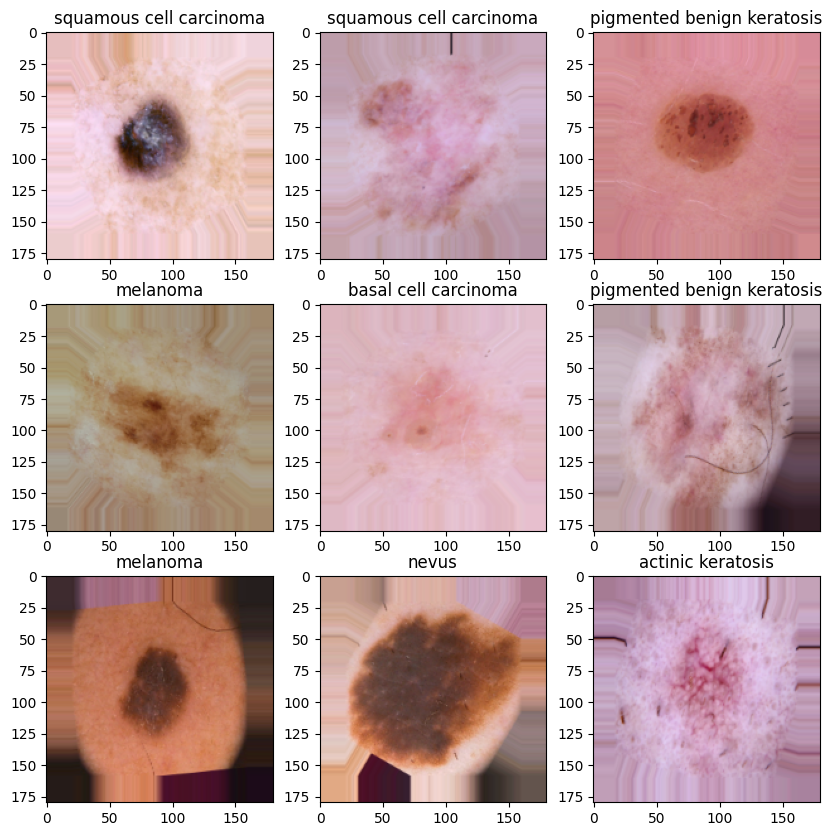

In [24]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10,10))
for img, label in list(train_ds)[:1]:
    for i in range(class_names.__len__()):
        x = plt.subplot(3,3, i+1)
        plt.imshow(augmented_model(img)[i].numpy().astype("uint8"))
        plt.title(class_names[label[i]])

### Todo:
### Create the model, compile and train the model


In [31]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes he
classes = len(class_names)
model = Sequential(
    [
        augmented_model,
        layers.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)),
    ]
)

model.add(
    Conv2D(
        filters=32,
        kernel_size=(5, 5),
        padding="Same",
        activation="relu",
        input_shape=(180, 180, 32),
    )
)
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding="Same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(5, 5), padding="Same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(5, 5), padding="Same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(classes, activation="softmax"))

In [33]:
#model.layers

### Compiling the model

In [34]:
## Your code goes here
# Sparse Categorical Cross-Entropy: Use this when your target variable is an integer representing the class index.
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
              loss= "sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Second_Model (Sequential)            │ (32, 180, 180, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_7 (Rescaling)              │ (32, 180, 180, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (32, 180, 180, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (32, 180, 180, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (32, 90, 90, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (32, 90, 90, 64)            │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (32, 45, 45, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (32, 45, 45, 64)            │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (32, 22, 22, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (32, 22, 22, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (32, 30976)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (32, 9)                     │         278,793 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 460,585 (1.76 MB)

 Trainable params: 460,585 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [37]:
## Your code goes here, note: train your model for 20 epochs
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 56s 977ms/step - accuracy: 0.1898 - loss: 2.1285 - val_accuracy: 0.2058 - val_loss: 2.0791
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.1926 - loss: 2.0558 - val_accuracy: 0.2573 - val_loss: 1.9396
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.2473 - loss: 1.9343 - val_accuracy: 0.2148 - val_loss: 2.0059
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.2492 - loss: 1.9534 - val_accuracy: 0.2953 - val_loss: 1.8970
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.2903 - loss: 1.8695 - val_accuracy: 0.3065 - val_loss: 1.8179
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.3385 - loss: 1.7833 - val_accuracy: 0.2953 - val_loss: 1.8176
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.3283 - loss: 1.7632 - val_accuracy: 0.3468 - val_loss: 1.8030
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.3732 - loss: 1.7250 - val_accuracy: 0.3423 - v

### Visualizing the results

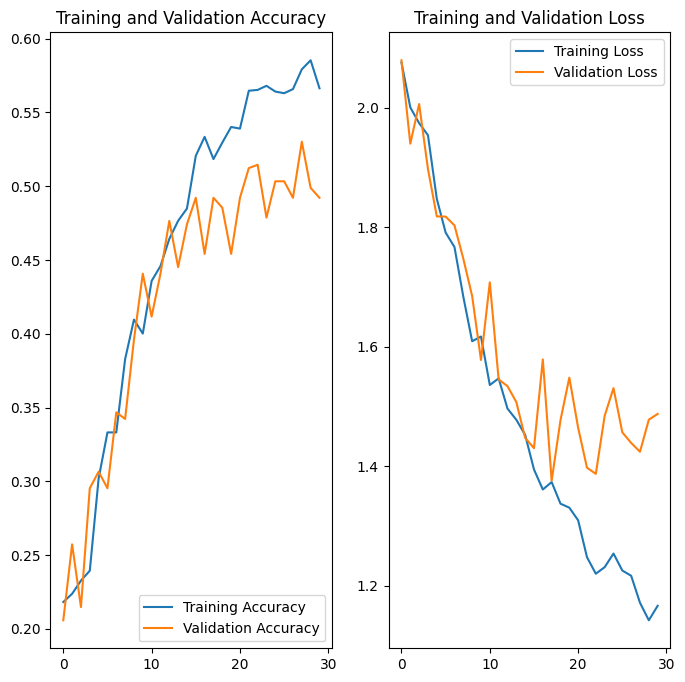

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Observations:

1.
Training and Validation Accuracy (Left Chart)
:
 - Both training and validation accuracy have improved compared to the previous model.
 - The curves for training and validation accuracy are closer to each other, indicating better generalization and reduced overfitting.
 - Validation accuracy now follows training accuracy more consistently, with both metrics gradually improving throughout the epochs.
2.
Training and Validation Loss (Right Chart)
:
 -  Both training and validation loss show a downward trend, which is expected.
 -  The gap between training and validation loss is narrower, indicating that the model benefits from data augmentation by preventing overfitting.
 -  Despite some fluctuations in validation loss, the trend is more stable than before, suggesting that the augmented model handles validation data more effectively.

3. Overall:

 - The addition of augmentation layers has likely helped improve generalization, as seen in the reduced divergence between training and validation metrics. This approach appears to be beneficial, leading to better performance and reduced overfitting.
 -  We may continue to fine-tune hyperparameters or experiment with additional augmentation techniques to further improve results.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

actinic keratosis
basal cell carcinoma
dermatofibroma
melanoma
nevus
pigmented benign keratosis
seborrheic keratosis
squamous cell carcinoma
vascular lesion


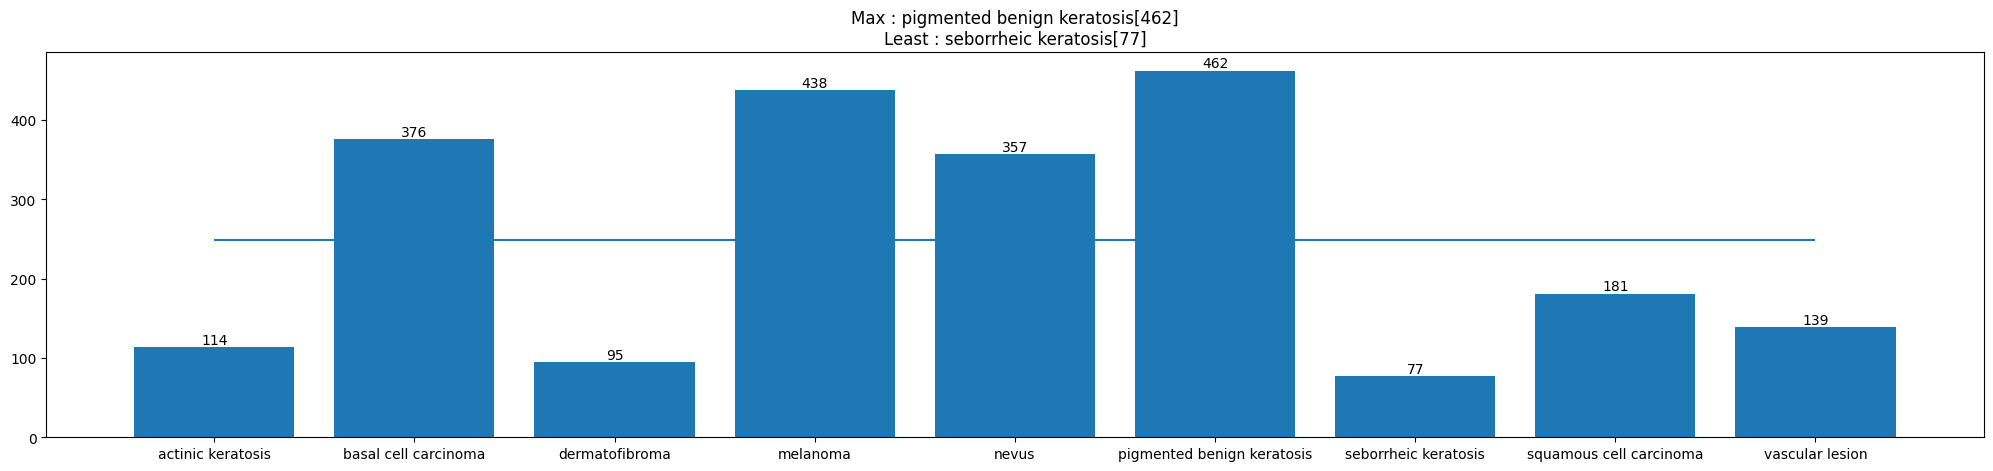

In [63]:
## Your code goes here.
count = []
least = 100000
least_class = None

maxx = 0
maxx_label = None

for class_ in class_names:
    print(class_)
    cnt = list(data_dir_train.glob(f"{class_}/*.jpg")).__len__()
    count.append(cnt)
    if cnt < least:
        least =  cnt
        least_class = class_

    if cnt > maxx:
        maxx = cnt
        maxx_label = class_
    

plt.figure(figsize=(25,5))
plt.bar(class_names, count)
for ind_, value in enumerate(count):
    plt.text(ind_, value, str(value), ha = "center", va = "bottom")
plt.hlines(y= sum(count)/len(count), xmin=0, xmax= 8)
plt.title(f"Max : {maxx_label}[{maxx}]\nLeast : {least_class}[{least}]")
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
- Answer : Seborrheic (77)
#### - Which classes dominate the data in terms proportionate number of samples?
- Answer : pigmented benign keratosis (462), melanoma (438)


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [64]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [45]:
path

'C:\\Users\\Siddhant.Ghute\\Desktop\\LJMU\\4. Course - Deep Learning 1\\CNN\\Melanoma_Assignment\\Skin_Cancer_Images'

In [46]:
#path_to_training_dataset="To do"
import Augmentor
for i in class_names[:]:
    p_path = f"{path}\\Train\\{i}"
    p = Augmentor.Pipeline(p_path)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.
    print("\n")

Initialised with 114 image(s) found.
Output directory set to C:\Users\Siddhant.Ghute\Desktop\LJMU\4. Course - Deep Learning 1\CNN\Melanoma_Assignment\Skin_Cancer_Images\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1E4EE2D5280>: 100%|█| 500/500 [00:02<00:00, 233.53 Samples




Initialised with 376 image(s) found.
Output directory set to C:\Users\Siddhant.Ghute\Desktop\LJMU\4. Course - Deep Learning 1\CNN\Melanoma_Assignment\Skin_Cancer_Images\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1E4EEE07560>: 100%|█| 500/500 [00:02<00:00, 226.15 Samples




Initialised with 95 image(s) found.
Output directory set to C:\Users\Siddhant.Ghute\Desktop\LJMU\4. Course - Deep Learning 1\CNN\Melanoma_Assignment\Skin_Cancer_Images\Train\dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1E480A3DBB0>: 100%|█| 500/500 [00:03<00:




Initialised with 438 image(s) found.
Output directory set to C:\Users\Siddhant.Ghute\Desktop\LJMU\4. Course - Deep Learning 1\CNN\Melanoma_Assignment\Skin_Cancer_Images\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=963x629 at 0x1E4EED99E80>: 100%|█| 500/500 [00:21<00:00, 23.70 Samples/




Initialised with 357 image(s) found.
Output directory set to C:\Users\Siddhant.Ghute\Desktop\LJMU\4. Course - Deep Learning 1\CNN\Melanoma_Assignment\Skin_Cancer_Images\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1E480A3E870>: 100%|█| 500/500 [00:16<00:00, 30.84 Samples




Initialised with 462 image(s) found.
Output directory set to C:\Users\Siddhant.Ghute\Desktop\LJMU\4. Course - Deep Learning 1\CNN\Melanoma_Assignment\Skin_Cancer_Images\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1E4EED634D0>: 100%|█| 500/500 [00:04<00:00, 116.64 Samples




Initialised with 77 image(s) found.
Output directory set to C:\Users\Siddhant.Ghute\Desktop\LJMU\4. Course - Deep Learning 1\CNN\Melanoma_Assignment\Skin_Cancer_Images\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1E4EEF68D10>: 100%|█| 500/500 [00:09<00:00, 50.02 Samples




Initialised with 181 image(s) found.
Output directory set to C:\Users\Siddhant.Ghute\Desktop\LJMU\4. Course - Deep Learning 1\CNN\Melanoma_Assignment\Skin_Cancer_Images\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1E480B8DFA0>: 100%|█| 500/500 [00:04<00:00, 104.17 Samples




Initialised with 139 image(s) found.
Output directory set to C:\Users\Siddhant.Ghute\Desktop\LJMU\4. Course - Deep Learning 1\CNN\Melanoma_Assignment\Skin_Cancer_Images\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1E4EEE06D50>: 100%|█| 500/500 [00:04<00:00, 107.26 Samples

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [54]:
original = len(list(data_dir_train.glob('*/*.jpg')))
augmented = len(list(data_dir_train.glob('*/*/*.jpg')))

print(f"Original Count : {original}\nAugmented Count : {augmented}\nTotal Count : {original+augmented}")

Original Count : 2239
Augmented Count : 4500
Total Count : 6739


### Lets see the distribution of augmented data after adding new images to the original training data.

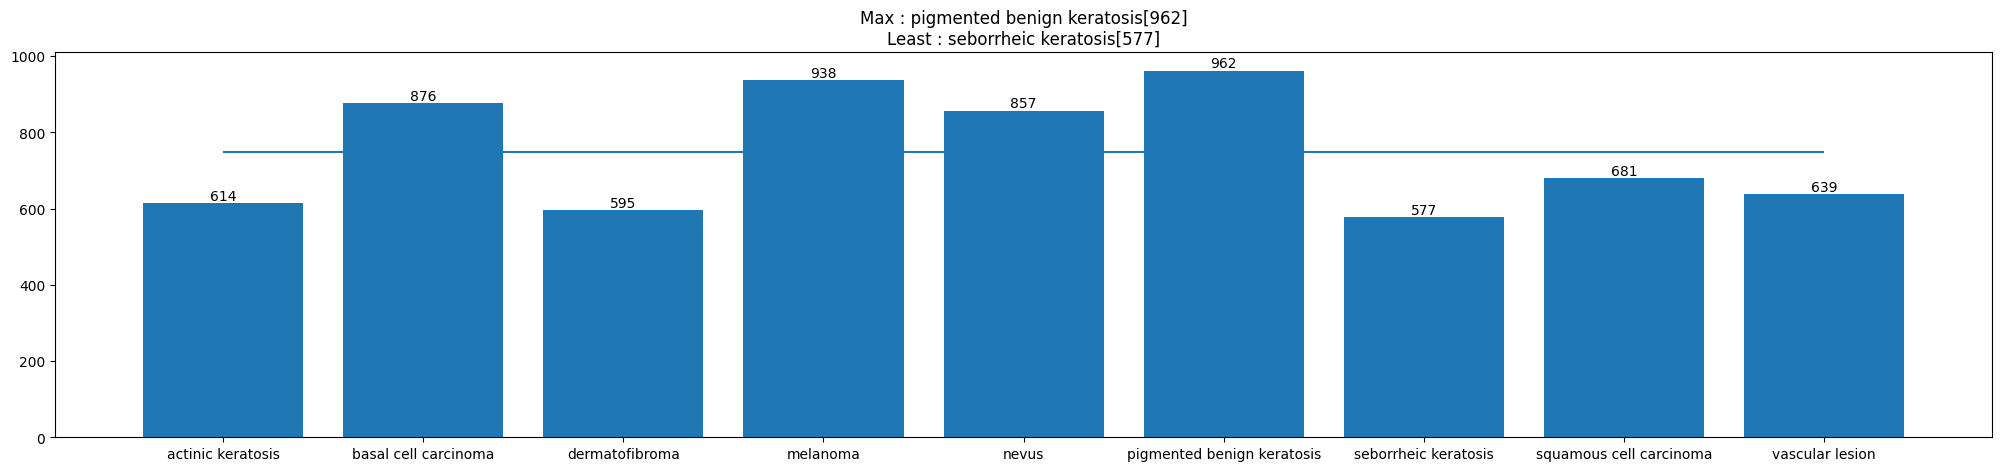

In [55]:
count = []
least = 100000
least_class = None

maxx = 0
maxx_label = None

for class_ in class_names:
    cnt = list(data_dir_train.glob(f"{class_}/*.jpg")).__len__()
    cnt += list(data_dir_train.glob(f"{class_}/output/*.jpg")).__len__()
    count.append(cnt)
    if cnt < least:
        least =  cnt
        least_class = class_

    if cnt > maxx:
        maxx = cnt
        maxx_label = class_
        
plt.figure(figsize=(25,5))
plt.bar(class_names, count)
for ind_, value in enumerate(count):
    plt.text(ind_, value, str(value), ha = "center", va = "bottom")
plt.hlines(y= sum(count)/len(count), xmin=0, xmax= 8)
plt.title(f"Max : {maxx_label}[{maxx}]\nLeast : {least_class}[{least}]")
plt.show()    

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [56]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [69]:
data_dir_train

WindowsPath('C:/Users/Siddhant.Ghute/Desktop/LJMU/4. Course - Deep Learning 1/CNN/Melanoma_Assignment/Skin_Cancer_Images/train')

In [77]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training" ,## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [79]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [85]:
## your code goes here
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes he
classes = len(class_names)
model = Sequential(
    [
        layers.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)),
    ]
)

model.add(Conv2D(filters=32,kernel_size=(5, 5),padding="Same",activation="relu",input_shape=(180, 180, 32)))
#model.add(layers.BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=(5, 5), padding="Same", activation="relu"))
#model.add(layers.BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(5, 5), padding="Same", activation="relu"))
#model.add(layers.BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(5, 5), padding="Same", activation="relu"))
#model.add(layers.BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(classes, activation="softmax"))

C:\Users\Siddhant.Ghute\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\Siddhant.Ghute\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [86]:
## your code goes here
# Sparse Categorical Cross-Entropy: Use this when your target variable is an integer representing the class index.
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
              loss= "sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [87]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 180, 180, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 180, 180, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 90, 90, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 45, 45, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │         278,793 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 460,585 (1.76 MB)

 Trainable params: 460,585 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

#### **Todo:**  Train your model

In [88]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 389s 2s/step - accuracy: 0.1585 - loss: 2.2118 - val_accuracy: 0.3363 - val_loss: 1.7511
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.3605 - loss: 1.6795 - val_accuracy: 0.4195 - val_loss: 1.5368
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 421s 2s/step - accuracy: 0.4011 - loss: 1.5754 - val_accuracy: 0.4291 - val_loss: 1.5529
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 433s 3s/step - accuracy: 0.4414 - loss: 1.4543 - val_accuracy: 0.4781 - val_loss: 1.3887
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 414s 2s/step - accuracy: 0.4856 - loss: 1.3733 - val_accuracy: 0.5122 - val_loss: 1.3170
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 435s 3s/step - accuracy: 0.5259 - loss: 1.2482 - val_accuracy: 0.4373 - val_loss: 1.6504
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 419s 2s/step - accuracy: 0.5423 - loss: 1.2196 - val_accuracy: 0.5657 - val_loss: 1.1668
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 433s 3s/step - accuracy: 0.5935 - loss: 1.0818 - val_accu

#### **Todo:**  Visualize the model results

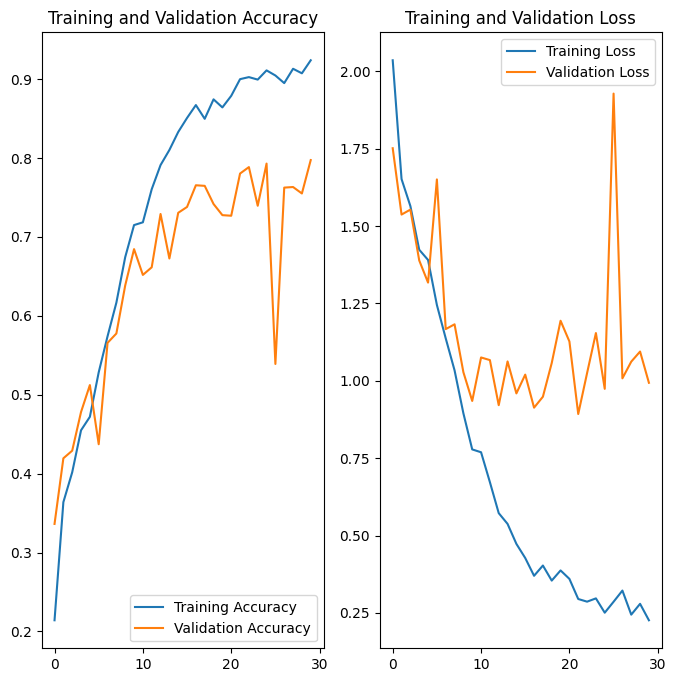

In [89]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



This graphs reflects the performance of the model after balancing the data by adding 500 images to each class category.

Observations:

1. Training and Validation Accuracy (Left Chart):
 - Training accuracy continues to improve steadily, approaching 0.95 by the end of the 30 epochs.
 - Validation accuracy, however, shows significant fluctuations, suggesting that the model’s performance on the validation set is unstable.
 - While the model achieves higher validation accuracy compared to earlier runs, the sharp drops indicate potential inconsistencies in generalization, possibly due to overfitting or the presence of noisy data in the validation set.

2. Training and Validation Loss (Right Chart):
 - Training loss decreases consistently, indicating effective learning of the training data.
 - Validation loss is notably erratic, with sharp spikes throughout the training. This indicates instability in the model’s predictions on validation data, suggesting that the model may struggle to generalize well despite the increased data.
 - The gap between training and validation loss is wider, which might imply overfitting, despite the balanced dataset.

3. Overall:
Balancing the dataset by adding more images appears to have improved training accuracy but introduced instability in validation performance. This could be due to:
 - Potential overfitting, as indicated by the gap between training and validation metrics.
 - Class imbalance being mitigated to some extent, but other factors like class overlap, noise, or insufficient regularization could be affecting performance.

4. Suggestions for Improvement:
 - Implement Regularization: Techniques like dropout or weight regularization may help stabilize validation performance.
 - Early Stopping: Use early stopping to prevent overfitting by halting training once validation loss consistently increases.
 - Data Augmentation: Further augmenting the dataset may improve generalization and reduce the variability seen in validation accuracy and loss.
 - Layers: Adding more dense layers and Batchnormalization layers.